In [1]:
import numpy as np 
import pandas as pd 
import time



from sklearn.model_selection import train_test_split, GridSearchCV, KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score


from sklearn import tree
from xgboost import XGBClassifier


%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:

# Esto es para acceder al directorio de arcgivos de Kaggle
# No hace falta correrlo si se tienen los datos en forma local
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/this-week-in-chess-archive/twic_master.csv
/kaggle/input/this-week-in-chess-archive/twic_master.parquet
/kaggle/input/this-week-in-chess-archive/metadata.csv
/kaggle/input/this-week-in-chess-archive/pgns/twic1032.pgn
/kaggle/input/this-week-in-chess-archive/pgns/twic1351.pgn
/kaggle/input/this-week-in-chess-archive/pgns/twic1167.pgn
/kaggle/input/this-week-in-chess-archive/pgns/twic1452.pgn
/kaggle/input/this-week-in-chess-archive/pgns/twic963.pgn
/kaggle/input/this-week-in-chess-archive/pgns/twic1027.pgn
/kaggle/input/this-week-in-chess-archive/pgns/twic1179.pgn
/kaggle/input/this-week-in-chess-archive/pgns/twic1133.pgn
/kaggle/input/this-week-in-chess-archive/pgns/twic1176.pgn
/kaggle/input/this-week-in-chess-archive/pgns/twic1442.pgn
/kaggle/input/this-week-in-chess-archive/pgns/twic1279.pgn
/kaggle/input/this-week-in-chess-archive/pgns/twic1342.pgn
/kaggle/input/this-week-in-chess-archive/pgns/twic1069.pgn
/kaggle/input/this-week-in-chess-archive/pgns/twic1195.pgn
/ka

In [3]:
# llamo al archivo "twic_master.csv" y creo el dataframe
df = pd.read_csv('/kaggle/input/this-week-in-chess-archive/twic_master.csv')


# esto es para que muestre todas las columnas del df
pd.set_option('display.max_columns', None) 

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3552: DtypeWarning: Columns (10,13,14,23,25) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
# Casi 2 millones de partidas
df.shape

(1971319, 29)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1971319 entries, 0 to 1971318
Data columns (total 29 columns):
 #   Column          Dtype  
---  ------          -----  
 0   twic_number     int64  
 1   White           object 
 2   Black           object 
 3   Date            object 
 4   EventDate       object 
 5   Event           object 
 6   Result          object 
 7   mainline_moves  object 
 8   Site            object 
 9   Online          bool   
 10  Round           object 
 11  ECO             object 
 12  Opening         object 
 13  WhiteFideId     object 
 14  BlackFideId     object 
 15  WhiteElo        float64
 16  BlackElo        float64
 17  Variation       object 
 18  WhiteTitle      object 
 19  BlackTitle      object 
 20  WhiteTeam       object 
 21  BlackTeam       object 
 22  EventType       object 
 23  FEN             object 
 24  SetUp           float64
 25  Variant         object 
 26  Board           float64
 27  PlyCount        float64
 28  EventCategor

Las columnas SetUp, FEN y Variant cuando no son nulas hacen referencia a la modalidad chess960. Voy a dropear los registros de esta modalidad, son alrededor de 550 partidas.

Las columnas PlyCount, Board, EventCategory, BlackTeam y WhiteTeam no me aportan nada interesante. Las primeras tres son casi todas nulas, y los equipos no interesan.

In [6]:
# Tiro las columnas que no interesan
df = df.drop(["PlyCount", "Board", "EventCategory", "BlackTeam", "WhiteTeam"], axis=1)

In [7]:
# Primero me quedo solo con los registros nulos en las columnas relacionadas con la modalidad 960
# De este modo me voy a quedar con las partidas que NO son 960chess
df = df[ (df.Variant.isna()) & (df.FEN.isna()) & (df.SetUp.isna()) ]

# Despues tiro estas columnas que ya no me dicen nada
df = df.drop(["Variant", "FEN", "SetUp"], axis=1)

In [8]:
display(df.shape)
df.columns

(1970769, 21)

Index(['twic_number', 'White', 'Black', 'Date', 'EventDate', 'Event', 'Result',
       'mainline_moves', 'Site', 'Online', 'Round', 'ECO', 'Opening',
       'WhiteFideId', 'BlackFideId', 'WhiteElo', 'BlackElo', 'Variation',
       'WhiteTitle', 'BlackTitle', 'EventType'],
      dtype='object')

In [9]:
# Vamos a poner todas las letras en minuscula y eliminar espacios en los extremos
# En "mainline_moves" y "ECO" NO toco las mayúsculas ya tienen relevancia en la notación.
cols = ["White", "Black", "Event", "Site", "Opening", "Variation", "WhiteTitle", "BlackTitle", "EventType"]
for feature in cols:
    
    df[feature] = df[feature].str.lower().str.strip()


In [10]:
# Parece que son todas blitz y rapidas. No parece haber ni clasicas, ni bullet.
display(df.EventType.value_counts())
# Pero hay muchos nulos (90%)
print("\nPrevalencia de nulos")
df.EventType.isna().value_counts(normalize=True)

team                  80971
swiss                 54121
blitz                 17099
team-tourn             9879
tourn                  9488
rapid                  7267
team-swiss             3788
k.o.                   2977
swiss (blitz)          2188
k.o. blitz              915
swiss (rapid)           485
team-match              400
team-tourn (rapid)      362
match                   334
schev                   320
match (blitz)           207
tourn (rapid)           197
tourn (blitz)           197
match (rapid)           158
k.o. (blitz)            150
team-swiss (rapid)      112
team (rapid)            109
team-match (blitz)       94
tourn (corr)             91
team-                    80
team-schev (blitz)       64
schev (rapid)            64
schev (blitz)            40
team-schev (rapid)       32
team-match (rapid)       22
k.o. rapid               17
team-k.o.                16
simul                    15
game (blitz)              1
game                      1
Name: EventType, dty


Prevalencia de nulos


True     0.902444
False    0.097556
Name: EventType, dtype: float64

In [11]:
# Vamos a ver el evento que invita, a ver si podemos asegurarnos que sólo hay partidas rápidas:
# Por ejemplo el torneo de candidatos, el tata steel, la sinquefiels cup de st louis, o los grand prix son a tiempo clásico, veamos si están:
df[(df.Event.str.contains("candidates")) | (df.Event.str.contains("sinquefield")) | (df.Event.str.contains("tata")) | (df.Event.str.contains("grand prix"))]

,twic_number,White,Black,Date,EventDate,Event,Result,mainline_moves,Site,Online,Round,ECO,Opening,WhiteFideId,BlackFideId,WhiteElo,BlackElo,Variation,WhiteTitle,BlackTitle,EventType
35524,949,"aronian,l","van wely,l",2013-01-12,2013.01.12,75th tata steel gpa,1/2-1/2,1. d4 Nf6 2. c4 g6 3. Nc3 Bg7 4. e4 d6 5. Nf3 ...,wijk aan zee ned,False,1.1,E90,king's indian,13300474.0,1000268.0,2802.0,2679.0,5.nf3,gm,gm,NaN
35525,949,"carlsen,m","caruana,f",2013-01-12,2013.01.12,75th tata steel gpa,1/2-1/2,1. c4 g6 2. e4 e5 3. Nc3 Bg7 4. g3 d6 5. Nge2 ...,wijk aan zee ned,False,1.2,A10,english,1503014.0,2020009.0,2861.0,2781.0,adorjan defence,gm,gm,NaN
35526,949,"harikrishna,p","giri,a",2013-01-12,2013.01.12,75th tata steel gpa,1-0,1. e4 e6 2. d4 d5 3. Nc3 dxe4 4. Nxe4 Nd7 5. N...,wijk aan zee ned,False,1.3,C10,french,5007003.0,24116068.0,2698.0,2720.0,rubinstein variation,gm,gm,NaN
35527,949,"anand,v","nakamura,hi",2013-01-12,2013.01.12,75th tata steel gpa,1/2-1/2,1. e4 e6 2. d4 d5 3. Nc3 Nf6 4. e5 Nfd7 5. f4 ...,wijk aan zee ned,False,1.4,C11,french,5000017.0,2016192.0,2772.0,2769.0,"steinitz, boleslavsky variation",gm,gm,NaN
35528,949,"sokolov,ivan",wang hao,2013-01-12,2013.01.12,75th tata steel gpa,1/2-1/2,1. d4 Nf6 2. c4 e6 3. Nc3 Bb4 4. e3 O-O 5. Bd3...,wijk aan zee ned,False,1.5,E52,nimzo-indian,14400030.0,8602883.0,2663.0,2752.0,"4.e3, main line with ...b6",gm,gm,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1957204,1315,"van dael,siem","vogel,roven",2020-01-20,2020.01.17,82nd tata steel qualifier,1-0,1. e4 c5 2. Nf3 d6 3. d4 cxd4 4. Nxd4 Nf6 5. N...,wijk aan zee ned,False,4.1,B56,sicilian,1049771.0,12908088.0,2252.0,2465.0,NaN,fm,im,NaN
1957205,1315,"slingerland,f","akash,g",2020-01-20,2020.01.17,82nd tata steel qualifier,0-1,1. e4 c5 2. Nf3 d6 3. d4 cxd4 4. Nxd4 Nf6 5. N...,wijk aan zee ned,False,4.2,B58,sicilian,1002473.0,5040299.0,2333.0,2461.0,boleslavsky variation,im,im,NaN
1957206,1315,"beukema,s","pijpers,a",2020-01-20,2020.01.17,82nd tata steel qualifier,0-1,1. e4 c5 2. Nf3 d6 3. d4 cxd4 4. Qxd4 Nc6 5. B...,wijk aan zee ned,False,4.3,B53,"sicilian, chekhover variation",1024523.0,1019554.0,2389.0,2480.0,NaN,im,im,NaN
1957207,1315,"de boer,eelke","zwirs,nico",2020-01-20,2020.01.17,82nd tata steel qualifier,0-1,1. e4 c5 2. Nf3 d6 3. d4 cxd4 4. Nxd4 Nf6 5. N...,wijk aan zee ned,False,4.4,B56,sicilian,1048120.0,1036432.0,2324.0,2418.0,NaN,fm,im,NaN


In [12]:
# Están todas las partidas. Sólo que las clasicas tienen "EventType"= nan
# Habría que separar en clásicas, rápidas y blitz.
# Me parece más interesante de analizar la rápidas y blitz, ya que va a haber
# menor porcentaje de empates.

In [13]:
display(df.Event.value_counts())


pro league group stage              7861
ch-fra blitz online qual            4900
djerba women online 2020            4651
world youth u16 olympiad            4275
44th olympiad 2022                  4070
                                    ... 
lviv vs odessa euromaidan m 2014       1
122nd us open armageddon               1
9th bilbao living chess                1
us chess masters tb 2018               1
7th gashimov mem tb                    1
Name: Event, Length: 11148, dtype: int64

In [14]:
# Los títulos más comunes son gran maestro, maestro internacional, maetro fide y candidato a maestro fide, tanto para hombre como para mujeres.
df.WhiteTitle.value_counts()


gm        413226
im        308241
fm        291917
cm         56723
wfm        50710
wim        46374
wgm        39028
wcm        13825
wc           428
wf           356
nm           222
agm           41
sim           40
              34
aim           23
iv            18
mf            15
afm           14
v             12
iii           12
i             10
mc             8
1              7
mk             5
ii             4
vk             4
fc             4
â              2
i++            1
423947         1
411779         1
cn             1
2              1
--             1
Name: WhiteTitle, dtype: int64

In [15]:
# Quedémonos sólo con los títulos más comunes

#titulos = ["gm", "im", "fm", "cm", "wfm", "wim", "wgm", "wcm"]

#df = df[(df.WhiteTitle.isin(titulos)) & (df.BlackTitle.isin(titulos))]

#df.shape # Los registros se me van a la mitad

In [16]:
# Donde se jugo
df.Site.value_counts().head(50)

chess.com int          378763
lichess.org int         66776
st petersburg rus       29732
moscow rus              28948
tornelo int             28079
budapest hun            20793
sochi rus               18425
prague cze              18277
konya tur               17159
warsaw pol              16853
barcelona esp           16567
reykjavik isl           16396
berlin ger              16072
pardubice cze           15420
helsingor den           14724
batumi geo              12980
europe-echecs int       12860
belgrade srb            11908
czech republic cze      11570
florianopolis bra       11415
chennai ind             11121
austria aut             10773
caleta eng              10633
london eng              10392
khanty-mansiysk rus     10349
novi sad srb            10347
baku aze                10173
linares esp              9192
antalya tur              9182
skopje mkd               9018
riga lat                 8844
chess24.com int          8771
montevideo uru           8246
istanbul t

In [17]:
# Porcentaje de partidas presenciales y virtuales
df.Online.value_counts(normalize=True)

False    0.741988
True     0.258012
Name: Online, dtype: float64

In [18]:
print("Partidas online:")
display(df[df.Online==True].Site.value_counts())
print("\nPartidas presenciales:")
display(df[df.Online==False].Site.value_counts())

Partidas online:


chess.com int              378763
lichess.org int             66776
tornelo int                 28079
europe-echecs int           12860
chess24.com int              8771
europe-chess int             5065
icc int                      2616
playchess int                2362
tcec-chess.com int           1923
chessdom.com int              699
premium chess arena int       325
iccf int                      191
aunix int                      35
playchess.com int              11
chess supersite int             6
Name: Site, dtype: int64


Partidas presenciales:


st petersburg rus    29732
moscow rus           28948
budapest hun         20793
sochi rus            18425
prague cze           18277
                     ...  
malahide irl             2
kelheim ger              2
estepona esp             2
lieme ger                2
fredrikstad nor          2
Name: Site, Length: 1848, dtype: int64

In [19]:
# El evento que invita
df.Event.value_counts()

pro league group stage              7861
ch-fra blitz online qual            4900
djerba women online 2020            4651
world youth u16 olympiad            4275
44th olympiad 2022                  4070
                                    ... 
lviv vs odessa euromaidan m 2014       1
122nd us open armageddon               1
9th bilbao living chess                1
us chess masters tb 2018               1
7th gashimov mem tb                    1
Name: Event, Length: 11148, dtype: int64

In [20]:
# Mezclando todos los controles de tiempo tenemos 41% gana blancas, el 34% gana negras y el 25% es tablas
df.Result.value_counts(normalize=True)

1-0        4.080915e-01
0-1        3.370618e-01
1/2-1/2    2.548203e-01
*          7.611242e-06
+/-        5.074161e-06
0-0        4.566745e-06
-/+        3.551913e-06
-          2.537081e-06
1-0 ff     1.014832e-06
00-1       5.074161e-07
1/2 1/2    5.074161e-07
(+)-(-)    5.074161e-07
1-O        5.074161e-07
Name: Result, dtype: float64

In [21]:
# Ya que estamos filtramos los registros con resultados mal cargados
display(df.shape)
df = df[(df.Result=="1-0") | (df.Result=="0-1") | (df.Result=="1/2-1/2")]
display(df.shape)

(1970769, 21)

(1970717, 21)

In [22]:
# Voy a tirar la columna "Round", No me aporta nada.
df = df.drop(["Round"], axis=1)

In [23]:
def Nulos(dtf):
    out = pd.DataFrame(index=["Nulos %"])
    for col in dtf.columns:
        out[col] = dtf[col].isna().sum()/len(dtf)
    display(out)
    
Nulos(df)

,twic_number,White,Black,Date,EventDate,Event,Result,mainline_moves,Site,Online,ECO,Opening,WhiteFideId,BlackFideId,WhiteElo,BlackElo,Variation,WhiteTitle,BlackTitle,EventType
Nulos %,0.0,0.0,5.074295e-07,0.0,0.000506,0.0,0.0,0.005522,0.0,0.0,0.004197,0.007826,0.01301,0.013157,0.035313,0.036009,0.34861,0.380285,0.384146,0.902443


In [24]:
# No puedo dejar nulos registros con nulos de Elo o Id

indexo = df[ (df.WhiteElo.isna()) | (df.BlackElo.isna())|
            (df.WhiteFideId.isna()) | (df.BlackFideId.isna())].index
  
df.drop(indexo, inplace = True)
  
Nulos(df)

,twic_number,White,Black,Date,EventDate,Event,Result,mainline_moves,Site,Online,ECO,Opening,WhiteFideId,BlackFideId,WhiteElo,BlackElo,Variation,WhiteTitle,BlackTitle,EventType
Nulos %,0.0,0.0,0.0,0.0,0.000513,0.0,0.0,0.004601,0.0,0.0,0.003667,0.006861,0.0,0.0,0.0,0.0,0.340579,0.346226,0.350187,0.90482


In [25]:
# Pasemos los números de identificación fide que son tipo object a enteros:

df['WhiteFideId'] = pd.to_numeric(df['WhiteFideId']).convert_dtypes() 

df['BlackFideId'] = pd.to_numeric(df['BlackFideId']).convert_dtypes() 

In [26]:
# redefinamos los valores del target:

def xgb_target(valor):
    if valor=="1-0":
        return 0
    if valor=="0-1":
        return 1
    if valor=="1/2-1/2":
        return 2
    
df["Result"] = df.Result.apply(lambda x: xgb_target(x))

In [27]:
df.Result.value_counts(normalize=True)

0    0.404916
1    0.332179
2    0.262905
Name: Result, dtype: float64

In [28]:
# Hagamos un df con partidas blitz
df_bz = df[(df.Event.str.contains("blitz")) | (df.EventType.str.contains("blitz"))]
df_bz.shape

(91377, 20)

In [29]:
# Veamos ahora los resultados para blitz:
df_bz.Result.value_counts(normalize=True)

0    0.446064
1    0.387220
2    0.166716
Name: Result, dtype: float64

In [30]:
# Hagamos un df con partidas rápidas
df_rd = df[(df.Event.str.contains("rapid")) | (df.EventType.str.contains("rapid"))]
df_rd.shape

(68587, 20)

In [31]:
# Veamos los resultados para rápidas:
df_rd.Result.value_counts(normalize=True) 

0    0.410049
1    0.340983
2    0.248968
Name: Result, dtype: float64

Para blitz se minimizan los empates al 20% y la ventaja blanca.
Para rápidas aumentan los empates al 31% y la ventaja blanca.

In [32]:
# Así podemos contar el nro de movidas
len(df_rd.loc[0].mainline_moves.split())//3


72

In [33]:
Nulos(df_bz)
Nulos(df_rd)

,twic_number,White,Black,Date,EventDate,Event,Result,mainline_moves,Site,Online,ECO,Opening,WhiteFideId,BlackFideId,WhiteElo,BlackElo,Variation,WhiteTitle,BlackTitle,EventType
Nulos %,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.005417,0.0,0.0,0.005592,0.00881,0.0,0.0,0.0,0.0,0.375007,0.22892,0.231623,0.775283


,twic_number,White,Black,Date,EventDate,Event,Result,mainline_moves,Site,Online,ECO,Opening,WhiteFideId,BlackFideId,WhiteElo,BlackElo,Variation,WhiteTitle,BlackTitle,EventType
Nulos %,0.0,0.0,0.0,0.0,0.000394,0.0,0.0,0.007961,0.0,0.0,0.00885,0.013545,0.0,0.0,0.0,0.0,0.354134,0.227929,0.230539,0.878315


In [34]:
# Dropiemos "Titles", "variation" y "eventtype" que estan llenas de nulos
df_bz = df_bz.drop(["Variation", "WhiteTitle", "BlackTitle", "EventType"], axis=1)
df_rd = df_rd.drop(["Variation", "WhiteTitle", "BlackTitle", "EventType"], axis=1)

In [35]:
# Y tiremos también todos los registros que presenten algún nan:

df_bz = df_bz.dropna() 
display(df_bz.shape)

df_rd = df_rd.dropna() 
display(df_rd.shape)

(90571, 16)

(67632, 16)

In [36]:
Nulos(df_bz)
Nulos(df_rd)

,twic_number,White,Black,Date,EventDate,Event,Result,mainline_moves,Site,Online,ECO,Opening,WhiteFideId,BlackFideId,WhiteElo,BlackElo
Nulos %,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,twic_number,White,Black,Date,EventDate,Event,Result,mainline_moves,Site,Online,ECO,Opening,WhiteFideId,BlackFideId,WhiteElo,BlackElo
Nulos %,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [37]:
# Veamos los rangos de elo que nos quedaron en cada dataframe:
display( min([df_bz.WhiteElo.min(),df_bz.BlackElo.min()]) )
display( max([df_bz.WhiteElo.max(),df_bz.BlackElo.max()]) )

display( min([df_rd.WhiteElo.min(),df_rd.BlackElo.min()]) )
display( max([df_rd.WhiteElo.max(),df_rd.BlackElo.max()]) )


1001.0

2882.0

1001.0

2882.0

Ahora con los dataframes sin nans podemos empezar a ver si los resultados son separables a simple vista. Vamos con un pairplot.

In [38]:
# Agreguemos una columna que sea el cociente de los elos
df_bz["EloRatio"] = df_bz.WhiteElo/df_bz.BlackElo

df_rd["EloRatio"] = df_rd.WhiteElo/df_rd.BlackElo

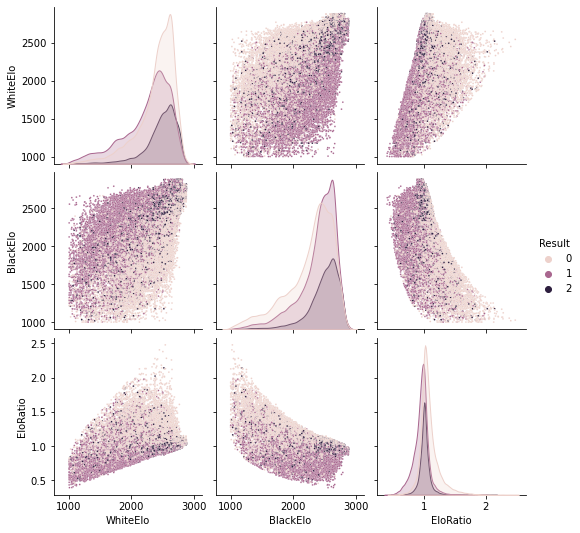

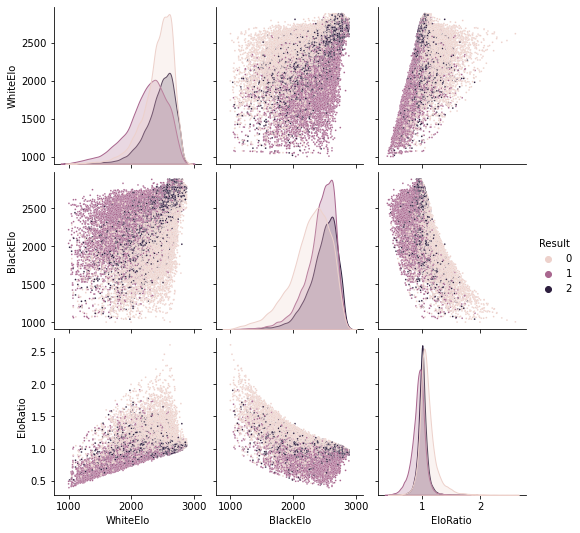

In [39]:
sns.pairplot(df_bz, vars=['WhiteElo', 'BlackElo',"EloRatio"], hue = "Result", plot_kws={"s": 3})#, markers=["o", "s"])
sns.pairplot(df_rd, vars=['WhiteElo', 'BlackElo',"EloRatio"], hue = "Result", plot_kws={"s": 3})#, markers=["o", "s"])


In [40]:
# Volvamos a ver los resultados:

display(df_bz.Result.value_counts(normalize=True))

display(df_rd.Result.value_counts(normalize=True))

0    0.447207
1    0.386249
2    0.166543
Name: Result, dtype: float64

0    0.410619
1    0.339957
2    0.249423
Name: Result, dtype: float64

In [41]:
# Vamos a ir viendo que se puede hacer con estos dos dataframes:
display(df_bz.shape)
display(df_rd.shape)

(90571, 17)

(67632, 17)

In [42]:
#df_bz.to_csv('chess_blitz.csv',index=False)

In [43]:
#df_rd.to_csv('chess_rapid.csv',index=False)

In [44]:
# Como vamos a estar probando distintos arboles y distintos sets de datos,
# me voy a armar una función que reciba los sets "X" e "y", y 
# haga el split, optimización/train y test,
# devolviendo el arbol entrenado y los sets de train y test utilizados:

def Arbol(X, y):
    
    #Split
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                   random_state=0, 
                                   test_size=0.25, 
                                   shuffle=True, stratify=y)
    
    #Optimización
    arbol = tree.DecisionTreeClassifier()

    criterio=["gini", "entropy"]
    max_depth_range = np.arange(6, 9)
    min_samples_split_range = np.arange(2, 5)
    param_grid = dict(criterion = criterio, 
                     max_depth = max_depth_range,
                     min_samples_split = min_samples_split_range)


    folds = StratifiedKFold(n_splits=5, random_state=0, shuffle=True)

    grid_arbol = GridSearchCV(arbol, param_grid, cv = folds, scoring='f1_micro', n_jobs=-1)

    grid_arbol.fit(X_train, y_train)

    print(f"Los mejores parámetros del árbol son:\n{grid_arbol.best_params_}")
    
    #Testeo
    y_pred = grid_arbol.predict(X_test)
    
    # Performance
    c = confusion_matrix(y_test, y_pred) # mostramos la matriz de confusion
    plt.figure(figsize=(3  ,3))
    ax= plt.subplot()
    sns.heatmap(c, annot=True, fmt="d")
    ax.set_xlabel('Valores predecidos')
    ax.set_ylabel('Valores de test')
    ax.xaxis.set_ticklabels(['N', 'B', "T"])
    ax.yaxis.set_ticklabels(['N', 'B', "T"])
    ax.set_title('Matriz de Confusión')
    plt.show()

    #display(confusion_matrix(y_test, y_pred))
    display(f1_score(y_test, y_pred, average="micro"))
    print(f"accuracy: {accuracy_score(y_test, y_pred)}")
    
    #llamo a la funcion con una tupla donde se guarda todo
    return (grid_arbol, X_train, y_train, X_test, y_test) 
    


In [45]:
# Arranquemos viendo cómo se predicen los resultados para las rápidas que están bastante balanceadas las tres etiquetas:

features = ["WhiteElo", "BlackElo"]
X = df_rd[features]
y = df_rd.Result



Los mejores parámetros del árbol son:
{'criterion': 'entropy', 'max_depth': 7, 'min_samples_split': 2}


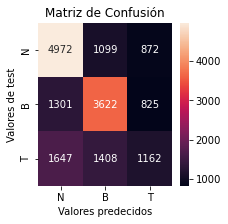

0.5770049680624556

accuracy: 0.5770049680624556


In [46]:

rd_elo = Arbol(X,y)

In [47]:
#rd_id = Arbol(X,y)

In [48]:

#bz_elo = Arbol(X,y)



Mientras averiguamos cómo se trabaja con matrices esparsas, podemos eliminar a dedo muchas dummies con un criterio del tipo: "Sólo quedan los IDs de los jugadores que más presencia tienen en el dataset".


In [49]:
# Voy a hacer dummies de los IDs de los jugadores que tengan mas de "N" partidas en el dataframe
# Lo voy a hacer con una función que tome el set X y "N" y lo devuelva con las dummies.
def OHE_ID(X, N):

    frecw = X.WhiteFideId.value_counts()

    idw = set(frecw[frecw>N].index)

    frecb = X.BlackFideId.value_counts()

    idb = set(frecb[frecb>N].index)

    ids = (idw | idb)

    print(f"Son {len(ids)} jugadores los que tienen más de {N} juegos con negras o blancas")

    # Veamos cuantas partidas participan estos jugadores
    partidas = (X[(X.WhiteFideId.isin(ids)) | (X.BlackFideId.isin(ids))].shape[0])
    print(f"Estos jugadores aparecen en {partidas} registros ")

    # Ahora creo dos columnas con los ids para blancas y negras, en donde
    # a los jugadores que no tengan la presencia deseada les quedará un
    # ID = -1

    X["IDW"] = X.WhiteFideId.apply(lambda x: x if x in ids else -1 )
    X["IDB"] = X.BlackFideId.apply(lambda x: x if x in ids else -1 )

    # Hago las dummies
    X = pd.get_dummies(X, columns=['IDW', 'IDB'], prefix=["W", "B"], prefix_sep='')

    # Dropeo columnas de IDs originales:
    X = X.drop(["WhiteFideId", "BlackFideId"], axis=1)

    return X

# Una función similar a esta puede aplicarse para generar dummies  de otra columna con el mismo criterio


In [51]:
y = df_rd.Result
X = df_rd[["WhiteElo", "BlackElo", "WhiteFideId", "BlackFideId"]]
display(X.shape)
display(X.head(1))

X = OHE_ID(X,100)
display(X.shape)
display(X.head(1))

(67632, 4)

,WhiteElo,BlackElo,WhiteFideId,BlackFideId
0,2527.0,2835.0,14109476,1503014


Son 71 jugadores los que tienen más de 100 juegos con negras o blancas
Estos jugadores aparecen en 15644 registros 


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(67632, 146)

,WhiteElo,BlackElo,W-1,W309095,W310204,W623539,W1170546,W1503014,W2000024,W2016192,W2020009,W2209390,W2285525,W2805677,W2902257,W3503240,W4100107,W4107012,W4108116,W4113403,W4116992,W4121830,W4123700,W4125029,W4126025,W4127870,W4128125,W4129199,W4132181,W4138147,W4138716,W4140419,W4147332,W4150120,W4153278,W4157800,W4158814,W4160258,W4162722,W4167570,W4168003,W4168119,W4169786,W4173708,W4182146,W4189302,W4192770,W4194985,W4195752,W4197143,W4641833,W5000017,W5029465,W5202213,W9301348,W12401137,W13300474,W13401319,W13401378,W13401653,W13504398,W14105730,W14109603,W14117908,W24101605,W24104272,W24104795,W24116068,W24125890,W24126055,W24130737,W24131423,W24133795,W24174041,B-1,B309095,B310204,B623539,B1170546,B1503014,B2000024,B2016192,B2020009,B2209390,B2285525,B2805677,B2902257,B3503240,B4100107,B4107012,B4108116,B4113403,B4116992,B4121830,B4123700,B4125029,B4126025,B4127870,B4128125,B4129199,B4132181,B4138147,B4138716,B4140419,B4147332,B4150120,B4153278,B4157800,B4158814,B4160258,B4162722,B4167570,B4168003,B4168119,B4169786,B4173708,B4182146,B4189302,B4192770,B4194985,B4195752,B4197143,B4641833,B5000017,B5029465,B5202213,B9301348,B12401137,B13300474,B13401319,B13401378,B13401653,B13504398,B14105730,B14109603,B14117908,B24101605,B24104272,B24104795,B24116068,B24125890,B24126055,B24130737,B24131423,B24133795,B24174041
0,2527.0,2835.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [52]:
# vamos a tunear xgb:
xgb = XGBClassifier(objective="multi:softmax", eval_metric="merror", seed=0, tree_method="approx", n_jobs=-1) # Vamos a usarlo como un histgb

l_rate = np.array([0.15,0.175,0.2])
n_est = np.array([400])
max_d = np.array([2])
col_bytree = np.array([0.3])

param_grid = dict(learning_rate = l_rate, 
                  n_estimators = n_est,
                  max_depth = max_d, 
                 colsample_bytree = col_bytree)
print(param_grid)

splits=2

folds = KFold(n_splits=splits, random_state=0, shuffle=True)

xgboosters = len(l_rate)*len(n_est)*len(max_d)*len(col_bytree)*splits
arbolitos = (n_est.sum())*len(l_rate)*len(max_d)*len(col_bytree)*splits

print(f"se van a entrenar {xgboosters} xgboosts")
print(f"se van a entrenar {arbolitos} árboles")

grid_xgb = GridSearchCV(xgb, param_grid, cv = folds, scoring='f1_micro', n_jobs=-1)


{'learning_rate': array([0.15 , 0.175, 0.2  ]), 'n_estimators': array([400]), 'max_depth': array([2]), 'colsample_bytree': array([0.3])}
se van a entrenar 6 xgboosts
se van a entrenar 2400 árboles


In [53]:
inicio = time.time()
grid_xgb.fit(X, y)
final = time.time()
print(f"tiempo de optimización: {np.around((final-inicio)/60,2)} minutos")
print(f"se entrenan {np.around(arbolitos/(final-inicio),1)} árboles por segundo")

tiempo de optimización: 9.31 minutos
se entrenan 4.3 árboles por segundo


In [54]:
grid_xgb_results = pd.DataFrame(grid_xgb.cv_results_)
gd_xgb = grid_xgb_results.loc[:,["param_n_estimators", "param_max_depth", "param_learning_rate", "param_colsample_bytree", "mean_test_score",	"std_test_score",	"rank_test_score"]].sort_values(by = "rank_test_score")
gd_xgb.set_index("rank_test_score", inplace=True)
gd_xgb

,param_n_estimators,param_max_depth,param_learning_rate,param_colsample_bytree,mean_test_score,std_test_score
rank_test_score,,,,,,
1,400,2,0.175,0.3,0.584886,0.000104
2,400,2,0.2,0.3,0.584856,0.000577
3,400,2,0.15,0.3,0.584812,0.000621


In [55]:
#  Ya tengo un f1 que supera 0.59, es cuestion de ir aumentando el learning rate, o los n_estimators

y_pr = grid_xgb.predict(X)

In [62]:
# Esta funcion toma los sets (X_test, y_test) y la predicción y_pred de un modelo
# Para entregar gráficas y métricas de score

def GRAFICAS(X_test, y_test, y_pred):
    
    y_test = pd.Series(y_test)
    y_pred = pd.Series(y_pred, index=y_test.index)
    
    c = confusion_matrix(y_test, y_pred) # mostramos la matriz de confusion
    plt.figure(figsize=(4  ,4))
    ax= plt.subplot()
    sns.heatmap(c, annot=True, fmt="d")
    ax.set_xlabel('Resultados predecidos')
    ax.set_ylabel('Resultados del test')
    ax.xaxis.set_ticklabels(['B(0)', 'N(1)', "T(2)"])
    ax.yaxis.set_ticklabels(['B(0)', 'N(1)', "T(2)"])
    ax.set_title('Matriz de Confusión')
    plt.show()
    

    print(f"El accuracy global del modelo es {accuracy_score(y_test, y_pred)}.")

    # Me armo un df de scores para cada resultado
    scores = pd.DataFrame({"Resultado":range(3),
                         "sensibilidad":pd.Series(recall_score(y_test, y_pred, average=None)),
                         "precisión":pd.Series(precision_score(y_test, y_pred, average=None)),
                         "f1":pd.Series(f1_score(y_test, y_pred, average=None))})
    scores.index.name='Resultado'
    print(f"\n\nEstos son los scores para cada resultado")

    display(scores.loc[:,"sensibilidad":].transpose().round(3))


    
    
    # hacemos un melt sobre Resultados para graficar
    df = scores.melt("Resultado", var_name='scores', value_name='Scores')
    # graficamos los scores para cada resultado
    sns.catplot(x="Resultado", y="Scores", hue='scores', data=df, kind='point')
    #plt.savefig(f"tp3_{type(modelo)}.png")
    plt.show()

    
    
    # Mostremos los errores cometidos

    err = y_test != y_pred # Hacemos una mascara de errores

    print(f"\n\nEstos son los errores de sensado (resultado mal identificado) y los errores de presición (resultado mal asignado):") 

    err1 = pd.DataFrame({"Mal sensado":y_test[err].value_counts(), "Mal predecido":y_pred[err].value_counts()})
    tot1 = err1["Mal sensado"].sum()
    tot2 = err1["Mal predecido"].sum()
    err1.loc["Total"] = [tot1,tot2]
    err1.index.name='Resultado'
    display(err1.transpose())

    # Un dataframe de errores:
    errores = pd.DataFrame({"y_test":y_test[err], "y_pred":y_pred[err]})
    errores["frecuencia"] = errores.apply(lambda x: c[x.y_test,x.y_pred] ,axis=1)
    errores = errores.sort_values(by=["frecuencia",'y_test', 'y_pred'],ascending=[False,False,False])

    print(f"\n\nAquí se muestra la frecuencia de cada uno de los {errores.shape[0]} errores cometidos:")
    display (errores.drop_duplicates().set_index('frecuencia').transpose())

    
    # Y para finalizar graficamos los errores de predicción,
    # con la perspectiva puesta en Los Elos, que son nuestros
    # mejores predictores
    X_test["Errores de Sensibilidad"] = y_test
        
    X_test["Errores de Precisión"] = y_pred
    
    print("\n\nEstos son los errores de recall:")
    sns.pairplot(X_test[err], vars=['WhiteElo', 'BlackElo'], hue = "Errores de Sensibilidad", plot_kws={"s": 3})
    plt.show()

    # Acá se va a ver cómo los modelos predicen empates sólo para los jugadores de mayor Elo.
    print("\n\nEstos son los errores de precisión:")
    sns.pairplot(X_test[err], vars=['WhiteElo', 'BlackElo'], hue = "Errores de Precisión", plot_kws={"s": 3})
    plt.show()


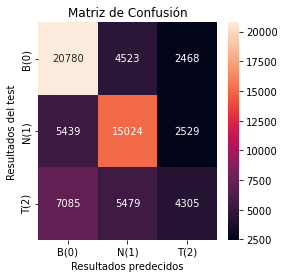

El accuracy global del modelo es 0.5930476697421339.


Estos son los scores para cada resultado


Resultado,0,1,2
sensibilidad,0.748,0.653,0.255
precisión,0.624,0.600,0.463
f1,0.680,0.626,0.329


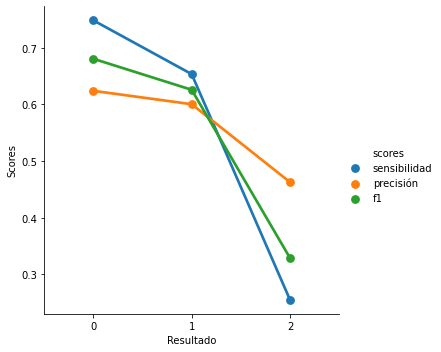



Estos son los errores de sensado (resultado mal identificado) y los errores de presición (resultado mal asignado):


Resultado,0,1,2,Total
Mal sensado,6991,7968,12564,27523
Mal predecido,12524,10002,4997,27523




Aquí se muestra la frecuencia de cada uno de los 27523 errores cometidos:


frecuencia,7085,5479,5439,4523,2529,2468
y_test,2,2,1,0,1,0
y_pred,0,1,0,1,2,2




Estos son los errores de recall:


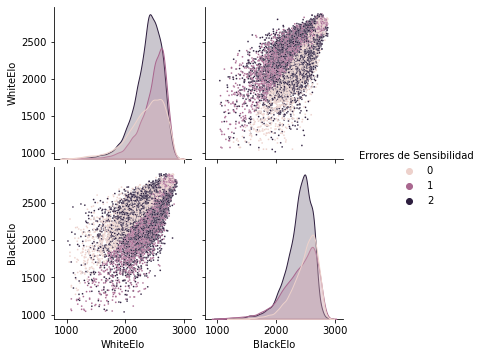



Estos son los errores de precisión:


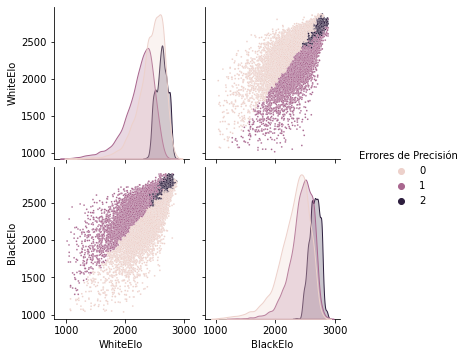

In [61]:
GRAFICAS(X, y, y_pr)